In [1]:
!pip install -q roboflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.8 MB/s eta 0:00:00


In [2]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from roboflow import Roboflow
from sklearn.metrics import average_precision_score

# Parameters
API_KEY =""#<--------------------------------- Replace this
img_size = (224, 224)
batch_size = 32
merged_dir = "/content/merged_dataset"
AUTOTUNE = tf.data.AUTOTUNE


In [3]:
datasets_info = [
    ("zaghamshamsi", "soil-classification", 1),
    ("ai-usztq", "toprak-verim-analizi", 1),
    ("demian-a5xbv", "soil-analysis-55sc2", 1)
]

os.makedirs(merged_dir, exist_ok=True)
rf = Roboflow(api_key=API_KEY)

for workspace, project_name, version_number in datasets_info:
    project = rf.workspace(workspace).project(project_name)
    version = project.version(version_number)
    dataset = version.download("folder")

    for split in ["train", "valid", "test"]:
        split_path = os.path.join(dataset.location, split)
        if not os.path.exists(split_path):
            continue

        for class_folder in os.listdir(split_path):
            class_path = os.path.join(split_path, class_folder)
            if os.path.isdir(class_path):
                dest_class_path = os.path.join(merged_dir, class_folder)
                os.makedirs(dest_class_path, exist_ok=True)

                for file in os.listdir(class_path):
                    src_file = os.path.join(class_path, file)
                    dst_file = os.path.join(dest_class_path, f"{workspace}_{project_name}_{file}")
                    shutil.copy(src_file, dst_file)


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Soil-Classification-1 in folder:: 100%|██████████| 4306/4306 [00:01<00:00, 2362.50it/s]


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Toprak-verim-Analizi-1 in folder:: 100%|██████████| 1163/1163 [00:00<00:00, 3743.40it/s]


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Soil-Analysis-1 in folder:: 100%|██████████| 162/162 [00:00<00:00, 4333.10it/s]


In [4]:
classes_to_keep = [
    "Clay soil", "Black Soil", "Alluvial soil",
    "Red soil",  "loam", "sandy",
]

for class_name in os.listdir(merged_dir):
    if class_name not in classes_to_keep:
        shutil.rmtree(os.path.join(merged_dir, class_name))
        print(f"❌ Deleted: {class_name}")


❌ Deleted: Sandy loam
❌ Deleted: heavy
❌ Deleted: Clayey soils
❌ Deleted: medium
❌ Deleted: Laterite soil
❌ Deleted: Yellow Soil
❌ Deleted: Sandy soil
❌ Deleted: Loamy soil


In [5]:
dataset_path = "/content/merged_dataset"
img_size = (224, 224)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE


In [6]:
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    validation_split=0.2,
    subset="training",
    image_size=img_size,
    batch_size=batch_size
)

raw_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    seed=123,
    validation_split=0.2,
    subset="validation",
    image_size=img_size,
    batch_size=batch_size
)

class_names = raw_train_ds.class_names
num_classes = len(class_names)

train_ds = raw_train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = raw_val_ds.prefetch(buffer_size=AUTOTUNE)


Found 3135 files belonging to 6 classes.
Using 2508 files for training.
Found 3135 files belonging to 6 classes.
Using 627 files for validation.


In [7]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
])


In [8]:
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model for feature extraction

model = keras.Sequential([
    keras.Input(shape=img_size + (3,)),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,313 (16.08 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [13]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25
)


Epoch 1/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 359ms/step - accuracy: 0.8730 - loss: 0.3814 - val_accuracy: 0.8405 - val_loss: 0.4664
Epoch 2/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 373ms/step - accuracy: 0.8883 - loss: 0.3546 - val_accuracy: 0.8421 - val_loss: 0.4427
Epoch 3/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 372ms/step - accuracy: 0.9036 - loss: 0.2835 - val_accuracy: 0.8453 - val_loss: 0.4210
Epoch 4/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 374ms/step - accuracy: 0.9146 - loss: 0.2737 - val_accuracy: 0.8565 - val_loss: 0.4060
Epoch 5/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 364ms/step - accuracy: 0.9114 - loss: 0.2741 - val_accuracy: 0.8596 - val_loss: 0.3842
Epoch 6/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 375ms/step - accuracy: 0.9204 - loss: 0.2349 - val_accuracy: 0.8772 - val_loss: 0.3647
Epoch 7/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 361ms/step - accuracy: 0.9228 - loss: 0.2324 - val_accuracy: 0.8804 - val_loss: 0.3465
Epoch 8/25
79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 374ms/step - accuracy: 0.9281 - loss: 0.2065 - val_accu

In [14]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

aps = []
for class_id in range(num_classes):
    y_true_binary = (y_true == class_id).astype(int)
    y_pred_binary = (y_pred == class_id).astype(int)
    ap = average_precision_score(y_true_binary, y_pred_binary)
    aps.append(ap)

mean_ap = np.mean(aps)
print(f"mAP: {mean_ap:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
mAP: 0.8152


In [11]:
base_model.trainable = True  # Unfreeze EfficientNet

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 76s 406ms/step - accuracy: 0.4826 - loss: 1.8569 - val_accuracy: 0.8373 - val_loss: 0.5517
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 366ms/step - accuracy: 0.6647 - loss: 1.0496 - val_accuracy: 0.8230 - val_loss: 0.5298
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 356ms/step - accuracy: 0.7513 - loss: 0.7498 - val_accuracy: 0.8230 - val_loss: 0.5321
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 374ms/step - accuracy: 0.8264 - loss: 0.5148 - val_accuracy: 0.8166 - val_loss: 0.5255
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 373ms/step - accuracy: 0.8523 - loss: 0.4282 - val_accuracy: 0.8278 - val_loss: 0.4905


In [12]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

aps = []
for class_id in range(num_classes):
    y_true_binary = (y_true == class_id).astype(int)
    y_pred_binary = (y_pred == class_id).astype(int)
    ap = average_precision_score(y_true_binary, y_pred_binary)
    aps.append(ap)

mean_ap = np.mean(aps)
print(f"mAP after Fine-Tuning: {mean_ap:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
mAP after Fine-Tuning: 0.6662


In [21]:
model.save("efficientnet_model_soils1.keras")

In [16]:
from tensorflow.keras.models import load_model

# Load the model you trained
model = load_model("/content/efficientnet_model_soils1.keras")


In [17]:
dataset_path = "/content/merged_dataset"

class_names = sorted(os.listdir(dataset_path))  # Sorted ensures consistent indexing
print("Classes:", class_names)


Classes: ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil', 'loam', 'sandy']


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


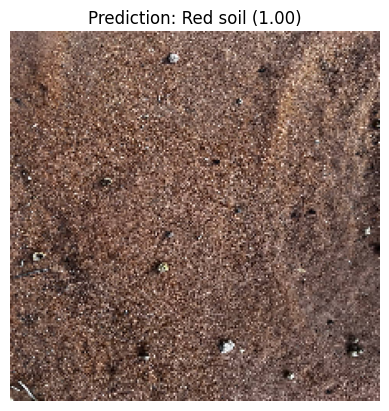

In [18]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

img_path = "/content/5807785126069913842.jpg"

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

# Predict
pred = model.predict(img_array)
pred_class = class_names[np.argmax(pred)]
confidence = np.max(pred)

# Show image and prediction
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {pred_class} ({confidence:.2f})")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


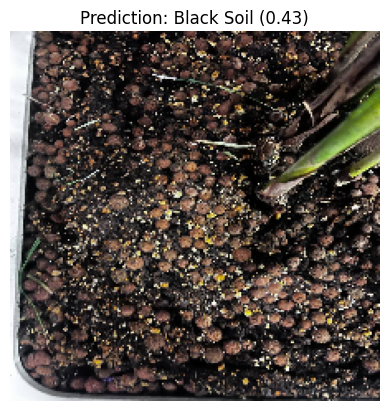

In [19]:
img_path = "/content/5807785126069913845.jpg"

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

# Predict
pred = model.predict(img_array)
pred_class = class_names[np.argmax(pred)]
confidence = np.max(pred)

# Show image and prediction
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {pred_class} ({confidence:.2f})")
plt.show()
